In [1]:
import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)
print('pytorch version = ',torch.__version__)

GPU name: NVIDIA GeForce RTX 2080 Ti, gpu_id: 0
cuda
pytorch version =  1.10.0


In [2]:
from typing import Optional, Union

import torch
from torch import Tensor

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import OptTensor, PairOptTensor, PairTensor
from torch_geometric.utils import remove_self_loops
try:
    from torch_cluster import knn
except ImportError:
    knn = None
import math
import numpy as np
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

class GravNetConv(MessagePassing):
    
    def __init__(self, in_channels: int, out_channels: int,
                 space_dimensions: int, propagate_dimensions: int, k: int,
                 num_workers: Optional[int] = None, **kwargs):
        super().__init__(aggr='mean', flow='source_to_target',
                         **kwargs)

        if knn is None:
            raise ImportError('`GravNetConv` requires `torch-cluster`.')

        if num_workers is not None:
            warnings.warn(
                "'num_workers' attribute in '{self.__class__.__name__}' is "
                "deprecated and will be removed in a future release")

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k = k

        self.lin_s = Linear(in_channels, space_dimensions)
        self.lin_h = Linear(in_channels, propagate_dimensions)

        self.lin_out1 = Linear(in_channels, out_channels, bias=False)
        self.lin_out2 = Linear(propagate_dimensions, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_s.reset_parameters()
        self.lin_h.reset_parameters()
        self.lin_out1.reset_parameters()
        self.lin_out2.reset_parameters()


    def forward(
            self, x: Union[Tensor, PairTensor],
            batch: Union[OptTensor, Optional[PairTensor]] = None) -> Tensor:
        # type: (Tensor, OptTensor) -> Tensor  # noqa
        # type: (PairTensor, Optional[PairTensor]) -> Tensor  # noqa
        """"""

        is_bipartite: bool = True
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
            is_bipartite = False

        if x[0].dim() != 2:
            raise ValueError("Static graphs not supported in 'GravNetConv'")

        b: PairOptTensor = (None, None)
        if isinstance(batch, Tensor):
            b = (batch, batch)
        elif isinstance(batch, tuple):
            assert batch is not None
            b = (batch[0], batch[1])

        h_l: Tensor = self.lin_h(x[0])
        s_l: Tensor = self.lin_s(x[0])
        s_r: Tensor = s_l
# x[0] = x[1], s_l = s_r 
        edge_index = knn(s_l, s_r, self.k, b[0], b[1]).flip([0])
        edge_weight = (s_l[edge_index[0]] - s_r[edge_index[1]]).pow(2).sum(-1)
        edge_weight = torch.exp(-150. * edge_weight)  # 10 gives a better spread
        # propagate_type: (x: OptPairTensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=(h_l, None),
                             edge_weight=edge_weight,
                             size=(s_l.size(0), s_r.size(0)))

        return self.lin_out1(x[1]) + self.lin_out2(out)


    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return x_j * edge_weight.unsqueeze(1)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, k={self.k})')

class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden)
        self.v  = nn.Parameter(v)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self, q, ref):       # query and reference
        self.batch_size = q.size(0)
        self.size = int(ref.size(0) / self.batch_size)
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        
        return u, ref

class LSTM(nn.Module):
    def __init__(self, n_hidden):
        super(LSTM, self).__init__()
        
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
    
    
    def forward(self, x, h, c):       # query and reference
        
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f * c + i * torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        
        h = o * torch.tanh(c)
        
        return h, c

In [3]:
import math
import numpy as np
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, space_dimensions=10, propagate_dimensions=22 ,k=20, aggr='max'):
        super().__init__()
        self.conv1 = GravNetConv(n_feature, n_hidden, space_dimensions, propagate_dimensions, k, aggr)
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.start_placeholder = nn.Parameter(torch.randn(n_hidden))
        self.encoder = LSTM(n_hidden)
        self.Pointer = Attention(n_hidden)
        self.batch_size = 0
        self.dim = n_hidden
        
        # trainable first hidden input
        h0 = torch.FloatTensor(n_hidden)
        c0 = torch.FloatTensor(n_hidden)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
    def forward(self, data, x, h=None, c=None):
        pos, batch, mask, B = data.pos, data.batch, data.mask, data.B
        self.batch_size = B
        if h is None or c is None:
            x          = self.start_placeholder
            h0 = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
            c0 = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)
            h0 = h0.unsqueeze(0).contiguous()
            c0 = c0.unsqueeze(0).contiguous()
            # let h0, c0 be the hidden variable of first turn
            h = h0.squeeze(0)
            c = c0.squeeze(0)
        else:
            x          = self.embedding_x(x)
        h, c = self.encoder(x, h, c)
        q = h
        GCNcontext = self.conv1(pos, batch)
        # GCNcontext.shape = (B*size, n_hidden)
        u1 ,_ = self.Pointer(q, GCNcontext)
        latent_u = u1.clone()
        # n_nidden as output dimension 
        
        out = 10 * torch.tanh(u1)
        out = out + mask
        return F.softmax(out, dim=1), h, c, latent_u

In [4]:
'''
This part I designed the rectangle-characterized TSP, that means for every step the agent walk through a corner,
then he travel through the whole rectangle using zig-zag, finally he ends up at one of the rest corners of 
the rextangle, so, it equals the agent walk through three points at one step, in practice, I add three points into 
mask to make them unselectable.
'''
def rectangle_process(temp,idx,Y,Y0,mask,k,B,i_step,path_gazebo, visit_count, visit_time_count, X_gcn_original, if_actor):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    rectangle_inf = idx/4
    feature_table = temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    if torch.cuda.is_available():
        feature_table = feature_table.cuda()
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    add_time = visit_time_count[zero_to_bsz, feature_table[:,0].data]*((range_of_wait/2)*speed_of_nozzle)
    if torch.cuda.is_available():
        add_time = add_time.cuda()
    Y_corner[:,dimension-2] = add_time
    X_gcn_transfer = X_gcn_original.clone()
    for i in range(B):
        X_gcn_transfer[i][idx.data[i]][dimension-2] = (add_time[i]/scale_of_the_map[0])
        X_gcn_transfer[i][feature_table[:,0].data[i]][dimension-2] = (add_time[i]/scale_of_the_map[0])
        X_gcn_transfer[i][feature_table[:,1].data[i]][dimension-2] = (add_time[i]/scale_of_the_map[0])
        X_gcn_transfer[i][feature_table[:,2].data[i]][dimension-2] = (add_time[i]/scale_of_the_map[0])
    if (i_step % 100 == 0)and(if_actor):
        path_gazebo.append([idx.data[0].tolist(),feature_table[:,0].data[0].tolist()])
    if k ==0:
        if torch.cuda.is_available():
            reward = torch.zeros(B).cuda()
        else:
            reward = torch.zeros(B)
    if k > 0:
        reward = torch.sum((Y1[:,(0,1)] - Y0[:,(0,1)])**2 , dim=1 )**0.5
        reward += torch.sum((Y_corner[:,(0,1)] - Y1[:,(0,1)])**2 , dim=1 )**0.5
        #dis = (Y1 - Y0)**2
        #dis_1 = (Y_corner - Y1)**2
        #reward = torch.maximum(dis[:,0],dis[:,1])**0.5
        #reward += torch.maximum(dis_1[:,0],dis_1[:,1])**0.5  
    visit_count[zero_to_bsz, idx.data] -= 1
    visit_count[zero_to_bsz, feature_table[:,0].data] -= 1
    visit_count[zero_to_bsz, feature_table[:,1].data] -= 1
    visit_count[zero_to_bsz, feature_table[:,2].data] -= 1
    visit_time_count[zero_to_bsz, idx.data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,0].data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,1].data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,2].data] += 1
    if_revisited = visit_count[zero_to_bsz, idx.data]<=0
    if_revisited = -np.inf*if_revisited
    if_revisited[if_revisited!=if_revisited] = 0
    mask[zero_to_bsz, idx.data] += if_revisited
    mask[zero_to_bsz, feature_table[:,0].data] += if_revisited
    mask[zero_to_bsz, feature_table[:,1].data] += if_revisited  
    mask[zero_to_bsz, feature_table[:,2].data] += if_revisited
    
    
    
    return Y, reward, Y_corner, Y_corner,feature_table[:,0], X_gcn_transfer

prepare to train
Hyper parameters:
learning rate 0.005
batch size 128
steps 500
epoch 100
tensor([[0.6662, 0.1900, 0.0000, 0.0012],
        [0.7912, 0.1900, 0.0000, 0.0012],
        [0.7912, 0.2075, 0.0000, 0.0012],
        [0.6662, 0.2075, 0.0000, 0.0012],
        [0.2475, 0.1000, 0.0000, 0.0025],
        [0.2950, 0.1000, 0.0000, 0.0025],
        [0.2950, 0.1312, 0.0000, 0.0025],
        [0.2475, 0.1312, 0.0000, 0.0025],
        [0.2138, 0.3500, 0.0000, 0.0012],
        [0.2663, 0.3500, 0.0000, 0.0012],
        [0.2663, 0.3887, 0.0000, 0.0012],
        [0.2138, 0.3887, 0.0000, 0.0012],
        [0.5125, 0.1525, 0.0000, 0.0037],
        [0.5450, 0.1525, 0.0000, 0.0037],
        [0.5450, 0.1675, 0.0000, 0.0037],
        [0.5125, 0.1675, 0.0000, 0.0037],
        [0.4588, 0.0887, 0.0000, 0.0037],
        [0.4800, 0.0887, 0.0000, 0.0037],
        [0.4800, 0.1037, 0.0000, 0.0037],
        [0.4588, 0.1037, 0.0000, 0.0037],
        [0.7400, 0.5625, 0.0000, 0.0037],
        [0.8587, 0.5625, 0.0

torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([1280

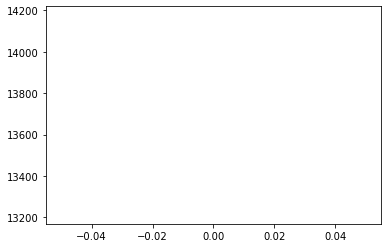

record the last path to gazebo for showing up


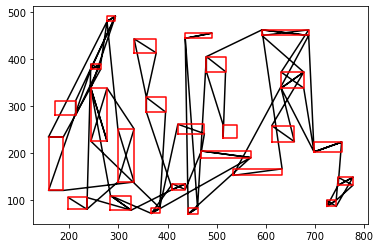

torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])
torch.Size([12800, 48])


In [ ]:
from torch_geometric.nn import knn_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from listofpathpoint import input_handler
import yaml
from torch.distributions.categorical import Categorical
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm_notebook
import torch.nn.functional as F
####### my own import file ##########
from listofpathpoint import input_handler
import cnc_input
import copy
#from hybrid_models import HPN
####### my own import file ##########
'''
so, the models we have are TransEncoderNet,
                            Attention
                            LSTM
                            HPN
each one have initial parameters and the forward part, 
once we have the forward part, the back propagation will 
finished automatically by pytorch  
'''
TOL = 1e-3
TINY = 1e-15
learning_rate = 0.005   #learning rate
B = 128          #batch size
B_valLoop = 1
steps = 500
n_epoch = 100       # epochs
map_number = 0
record_actor = []
record_critic = []
dimension = 4
speed_of_nozzle = 30
range_of_wait = 20
scale_of_the_map = (800,500,speed_of_nozzle*range_of_wait)
maplist = ['10&15data/25_chips/25_1.json'
          ,'10&15data/25_chips/25_1.json','10&15data/25_chips/25_1.json'\
          ,'10&15data/25_chips/25_1.json','10&15data/25_chips/25_1.json'\
          ,'10&15data/25_chips/25_1.json'
          ]
print('======================')
print('prepare to train')
print('======================')
print('Hyper parameters:')
print('learning rate', learning_rate)
print('batch size', B)
print('steps', steps)
print('epoch', n_epoch)
print('======================')

'''
instantiate a training network and a baseline network
'''
temp = input_handler(maplist[map_number])
x_gcn_temp, mask_list_num = temp.final_ver_points()

try:
    del Actor  # remove existing model
    del Critic # remove existing model
except:
    pass
Actor = Net(n_feature=4, n_hidden=48).to(device)
Critic = Net(n_feature=4, n_hidden=48).to(device)
optimizer = optim.Adam(Actor.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Putting Critic model on the eval mode
Actor = Actor.to(device)
Critic = Critic.to(device)
Critic.eval()

epoch_ckpt = 0
tot_time_ckpt = 0

val_mean = []
val_std = []
          
plot_performance_train = []
plot_performance_baseline = []
# recording the result of the resent epoch makes it available for future
#*********************# Uncomment these lines to load the previous check point
"""
checkpoint_file = "checkpoint/mutimap_20.pkl"
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
Critic.load_state_dict(checkpoint['model_baseline'])
Actor.load_state_dict(checkpoint['model_train'])
optimizer.load_state_dict(checkpoint['optimizer'])

print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
"""

#***********************# Uncomment these lines to load the previous check point

# Main training loop
# The core training concept mainly upon Sampling from the actor
# then taking the greedy action from the critic

start_training_time = time.time()
time_stamp = datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S") # Load the time stamp

C = 0       # baseline => the object which the actor can compare
R = 0       # reward
# load 100 points into the program 
x_gcn_temp = torch.Tensor(x_gcn_temp).type(torch.float)
x_gcn_temp /= scale_of_the_map[0]
X_temp, mask_list_num = temp.final_ver_points()
print(x_gcn_temp)
print(X_temp)
print(mask_list_num)
#change the waiting time to the distance that we can measure
size = len(X_temp)
zero_to_bsz = torch.arange(B, device = device) # a list contains 0 to (batch size -1)
batch = torch.arange(B)
batch = batch.repeat_interleave(size)
for corner in X_temp:
    corner[dimension -2] *= speed_of_nozzle
size_rec = mask_list_num[-1]
print(size_rec)

X_temp = torch.FloatTensor(X_temp)
visit_count_initial = X_temp[:,dimension-1]
visit_count_rec = []
for i in range(0,len(visit_count_initial),4):
    visit_count_rec.append(int(visit_count_initial[i]))
X = X_temp.repeat(B,1,1)
if torch.cuda.is_available():
    X = X.cuda()

for epoch in range(0, n_epoch):
    # re-start training with saved checkpoint
    epoch += epoch_ckpt # adding the number of the former epochs
    # Train the model for one epoch
    start = time.time() # record the starting time
    Actor.train() 
    path_gazebo = []
    for i_all in range(1, steps+1): # 1 ~ 2500 steps
        # mask some points that are not the first visited points
        if torch.cuda.is_available():
            R = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            logprobs = 0
            reward = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
            X_gcn_original = x_gcn_temp.repeat(B,1,1).cuda()
        else:
            R = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            logprobs = 0
            reward = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
            X_gcn_original = x_gcn_temp.repeat(B,1,1)
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        GCNcontext = None
        Y0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
            batch = batch.cuda()
        # Actor Sampling phase
        for k in range(size_rec):
            if k ==0:
                Y = X.view(B,size,dimension)
            X_gcn = X_gcn_original.view(B*size,dimension)
            data = Data(pos=X_gcn,batch=batch,mask=mask,B=B)
            output, h, c, _ = Actor(data, x=x, h=h, c=c)
            sampler = torch.distributions.Categorical(output)
            idx = sampler.sample()
            idx_recorder[:,k] = (idx/4).type(torch.long)
            # prepare for the back propagation of pytorch
            Y, reward, Y0, x, choosen_idx, X_gcn_original = rectangle_process(temp, idx,Y,Y0,mask,k,B,i_all,path_gazebo,
                                                visit_count, visit_time_count, X_gcn_original, if_actor=True)

            # change the input data X_gcn to match the current situation on map
            R += reward
            reward_recorder[:,k] = R
            logprobs += torch.log(output[zero_to_bsz, idx.data] + TINY)
            
        # now it's time to check if any trajectory should be punished due to waiting on the same rectangle

        trajec_count = 0
        if i_all%100 ==0:
            print(idx_recorder[0])
        for path_time in zip(idx_recorder,reward_recorder):
            idx_time = zip(path_time[0],path_time[1])
            idx_time = sorted(idx_time, key=lambda x: x[0])
            total_idx = 0
            extra_waiting_time = 0
            for item in visit_count_rec:
                compare_list = []
                if item>1:
                    for i in range(int(item)):
                        compare_list.append(idx_time[int(total_idx + i)][1])
                    compare_list.sort(reverse=True)
                    total_idx += item
                    for i in range(len(compare_list)-1):
                        dis_step = compare_list[i] - compare_list[i+1]
                        dry_time = (range_of_wait/2)*speed_of_nozzle
                        if (dis_step) < (dry_time):
                            extra_waiting_time += dry_time - dis_step
                else:
                    total_idx += item
            R[trajec_count] += extra_waiting_time
            trajec_count+=1
                    
                
        
# # critic baseline phase, use the baseline to compute the actual reward of agent at that time
        if torch.cuda.is_available():
            C = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            baseline = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
            X_gcn_original = x_gcn_temp.repeat(B,1,1).cuda()
        else:
            C = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            baseline = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
            X_gcn_original = x_gcn_temp.repeat(B,1,1)
        x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None
        Transcontext = None
        GCNcontext = None
        C0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
        # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
        with torch.no_grad():
            for k in range(size_rec): 
                if k ==0:
                    Y = X.view(B,size,dimension)
                #check if all the points to be masked,if so, raise the total reward R, and check again
                X_gcn = X_gcn_original.view(B*size,dimension)
                data = Data(pos=X_gcn,batch=batch,mask=mask,B=B)
                output, h, c, _ = Critic(data, x=x, h=h, c=c)
                idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
                idx_recorder[:,k] = (idx/4).type(torch.long)
                # prepare for the back propagation of pytorch
                Y, baseline, C0, x, choosen_idx, X_gcn_original = rectangle_process(temp,idx,Y,C0, mask,k,B,i,path_gazebo,
                                                   visit_count, visit_time_count, X_gcn_original, if_actor=False)
                C += baseline
                reward_recorder[:,k] = C
                    #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                C[trajec_count] += extra_waiting_time
                trajec_count+=1
        ###################
        # Loss and backprop handling 
        ###################
        loss = torch.mean((R - C) * logprobs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_all % 100 == 0:
            print("epoch:{}, batch:{}/{}, reward:{}".format(epoch, i_all, steps,R.mean().item()))
            record_actor.append(R.mean().tolist())
            record_critic.append(C.mean().tolist())
            plt.plot(record_actor,'r:')
            plt.plot(record_critic,'b:')
            plt.show()
        if i_all % 100 == 0:
            print("record the last path to gazebo for showing up")
            #starting to show the path on simulated enviroment of cnc_machine 
            the_resent_path = temp.zig_zag_path(path_gazebo,mask_list_num)
            data = {'path':the_resent_path}
            data_1 = {'corners':path_gazebo}
            pathpoints_dir = os.path.join("pathpoints")
            if not os.path.exists(pathpoints_dir):
                os.makedirs(pathpoints_dir)
            name = 'pathpoints/path_points '+str(i)+'.yaml'
            with open(name, 'w') as file:
                documents = yaml.dump(data,file)
                documents = yaml.dump(data_1,file)
            path_gazebo = []
    time_one_epoch = time.time() - start #recording the work time of one epoch
    time_tot = time.time() - start_training_time + tot_time_ckpt
    ###################
    # Evaluate train model and baseline 
    # in this phase we just solve random instances with the actor and the critic
    # compare this soluation if we get any improvment we'll transfer the actor's
    # weights into the critic
    ###################
    # putting the actor in the eval mode
    Actor.eval()
    
    mean_tour_length_actor = 0
    mean_tour_length_critic = 0

    for step in range(0,B_valLoop):
        
        # compute tour for model and baseline
        # mask some points that are not the first visited points
        if torch.cuda.is_available():
            R = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            reward = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
            X_gcn_original = x_gcn_temp.repeat(B,1,1).cuda()
        else:
            R = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            reward = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
            X_gcn_original = x_gcn_temp.repeat(B,1,1)
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        # set Y_ini to the out corner
        Transcontext = None
        GCNcontext = None
        Y0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()

        with torch.no_grad():
            for k in range(size_rec):
                if k==0:
                    Y = X.view(B,size,dimension)
                X_gcn = X_gcn_original.view(B*size,dimension)
                data = Data(pos=X_gcn,batch=batch,mask=mask,B=B)
                output, h, c, _ = Actor(data, x=x, h=h, c=c)
                idx = torch.argmax(output, dim=1)
                idx_recorder[:,k] = (idx/4).type(torch.long)
                #prepare for the back propagation of pytorch
                Y, reward, Y0, x, choosen_idx, X_gcn_original = rectangle_process(temp, idx,Y,Y0,mask,k,B,i,path_gazebo,
                                                    visit_count, visit_time_count, X_gcn_original, if_actor=False)
                R += reward
                reward_recorder[:,k] = R
            #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                R[trajec_count] += extra_waiting_time
                trajec_count+=1
            print('R_val = ',R[0])
        if torch.cuda.is_available():
            C = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            baseline = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
            X_gcn_original = x_gcn_temp.repeat(B,1,1).cuda()
        else:
            C = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            baseline = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
            X_gcn_original = x_gcn_temp.repeat(B,1,1)
        x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None
        Transcontext = None
        C0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
        # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
        with torch.no_grad():
            for k in range(size_rec): 
                if k ==0:
                    Y = X.view(B,size,dimension)
                #check if all the points to be masked,if so, raise the total reward R, and check again
                X_gcn = X_gcn_original.view(B*size,dimension)
                data = Data(pos=X_gcn,batch=batch,mask=mask,B=B)
                output, h, c, _ = Critic(data, x=x, h=h, c=c)
                idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
                idx_recorder[:,k] = (idx/4).type(torch.long)
                # prepare for the back propagation of pytorch
                Y, baseline, C0, x, choosen_idx, X_gcn_original = rectangle_process(temp,idx,Y,C0, mask,k,B,i,path_gazebo,
                                                   visit_count, visit_time_count, X_gcn_original, if_actor=False)
                C += baseline
                reward_recorder[:,k] = C
                #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                C[trajec_count] += extra_waiting_time
                trajec_count+=1
            print('C_val = ',C.mean().item())
        mean_tour_length_actor  += R.mean().item()
        mean_tour_length_critic += C.mean().item()

    mean_tour_length_actor  =  mean_tour_length_actor  / B_valLoop
    mean_tour_length_critic =  mean_tour_length_critic / B_valLoop
    # evaluate train model and baseline and update if train model is better

    update_baseline = mean_tour_length_actor + TOL < mean_tour_length_critic

    print('Avg Actor {} --- Avg Critic {}'.format(mean_tour_length_actor,mean_tour_length_critic))

    if update_baseline:
        Critic.load_state_dict(Actor.state_dict())
        print('My actor is going on the right road Hallelujah :) Updated')
    ###################
    # Valdiation train model and baseline on 1k random TSP instances
    ###################
    # erased by daniel due to the 1K tsp is not the scale I want to train  

    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_actor])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_critic])
    # compute the optimally gap ==> this is interesting because there is no LKH or other optimal algorithms 
    # for the problem like this rectangle characterized map
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_actor: {:.3f}, L_critic: {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_actor, mean_tour_length_critic, update_baseline)

    print(mystring_min)
    print('Save Checkpoints')

    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'model_baseline': Critic.state_dict(),
        'model_train': Actor.state_dict(),
        'optimizer': optimizer.state_dict(),
        },'{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(size) + "-gpu{}".format(gpu_id)))


  




                
            
                
        
                        

In [ ]:
embed_dim = 128
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GravNetConv
import torch.nn.functional as F
import torch

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = GravNetConv(-1, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = GravNetConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = GravNetConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        print(x.dtype)
        print(edge_index.dtype)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        print(x.shape)
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

In [ ]:
import torch
from torch_geometric.nn import knn_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
def train():
    model.train()
    loss_all = 0
    optimizer.zero_grad()
    output = model(data)
    print(output)
    label = data.y.to(device)
    loss = crit(output, label)
    loss.backward()
    optimizer.step()
    return loss
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
dataset = x.repeat(128,1)
x = x.repeat(128,1,1)
loader = DataLoader(dataset, batch_size=128, shuffle=True)
edge_index = torch.tensor([])
for x_seed in x:
    edge_index_temp = knn_graph(x_seed, k=1, loop=False)
    edge_index_temp = torch.unsqueeze(edge_index_temp, 0)
    edge_index = torch.cat((edge_index, edge_index_temp),0)
x = torch.Tensor(x).type(torch.float)
edge_index = torch.Tensor(edge_index).type(torch.long)
data = Data(x=x[0],edge_index=edge_index[0],batch=128)
# device = torch.device('cuda')
model = Net()#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()
train()

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool

path = osp.join(osp.dirname(osp.realpath('only_for_test')), '..', 'data/ModelNet10')
pre_transform, transform = T.NormalizeScale(), T.SamplePoints(1024)
train_dataset = ModelNet(path, '10', True, transform, pre_transform)
test_dataset = ModelNet(path, '10', False, transform, pre_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         num_workers=6)


class Net(torch.nn.Module):
    def __init__(self, out_channels, k=20, aggr='max'):
        super().__init__()

        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        self.lin1 = Linear(128 + 64, 1024)

        self.mlp = MLP([1024, 512, 256, out_channels], dropout=0.5,
                       batch_norm=False)

    def forward(self, data):
        pos, batch = data.pos, data.batch
        print(pos.shape)
        print(pos)
        x1 = self.conv1(pos, batch)
        print(x1.shape)
        x2 = self.conv2(x1, batch)
        print(x2.shape)
        out = self.lin1(torch.cat([x1, x2], dim=1))
        print(out.shape)
        out = global_max_pool(out, batch)
        out = self.mlp(out)
        return F.log_softmax(out, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(train_dataset.num_classes, k=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


def train():
    model.train()

    total_loss = 0
    print(train_loader)
    for data in train_loader:
        print(data)
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


for epoch in range(1, 201):
    loss = train()
    test_acc = test(test_loader)
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}')
    scheduler.step()

# 點雲圖處理模型的借鏡

In [ ]:
import warnings
from typing import Optional, Union

import torch
from torch import Tensor

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import OptTensor, PairOptTensor, PairTensor
from torch_geometric.utils import remove_self_loops
try:
    from torch_cluster import knn
except ImportError:
    knn = None


class GravNetConv(MessagePassing):
    
    def __init__(self, in_channels: int, out_channels: int,
                 space_dimensions: int, propagate_dimensions: int, k: int,
                 num_workers: Optional[int] = None, **kwargs):
        super().__init__(aggr='mean', flow='source_to_target',
                         **kwargs)

        if knn is None:
            raise ImportError('`GravNetConv` requires `torch-cluster`.')

        if num_workers is not None:
            warnings.warn(
                "'num_workers' attribute in '{self.__class__.__name__}' is "
                "deprecated and will be removed in a future release")

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k = k

        self.lin_s = Linear(in_channels, space_dimensions)
        self.lin_h = Linear(in_channels, propagate_dimensions)

        self.lin_out1 = Linear(in_channels, out_channels, bias=False)
        self.lin_out2 = Linear(2 * propagate_dimensions, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_s.reset_parameters()
        self.lin_h.reset_parameters()
        self.lin_out1.reset_parameters()
        self.lin_out2.reset_parameters()


    def forward(
            self, x: Union[Tensor, PairTensor],
            batch: Union[OptTensor, Optional[PairTensor]] = None) -> Tensor:
        # type: (Tensor, OptTensor) -> Tensor  # noqa
        # type: (PairTensor, Optional[PairTensor]) -> Tensor  # noqa
        """"""

        is_bipartite: bool = True
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
            is_bipartite = False

        if x[0].dim() != 2:
            raise ValueError("Static graphs not supported in 'GravNetConv'")

        b: PairOptTensor = (None, None)
        if isinstance(batch, Tensor):
            b = (batch, batch)
        elif isinstance(batch, tuple):
            assert batch is not None
            b = (batch[0], batch[1])

        h_l: Tensor = self.lin_h(x[0])
        s_l: Tensor = self.lin_s(x[0])
        s_r: Tensor = s_l
# x[0] = x[1], s_l = s_r 
        edge_index = knn(s_l, s_r, self.k+1, b[0], b[1]).flip([0])
        temp_edge = remove_self_loops(edge_index)
        edge_index = temp_edge[0]
        edge_weight = (s_l[edge_index[0]] - s_r[edge_index[1]]).pow(2).sum(-1)
        edge_weight = torch.exp(-20. * edge_weight)  # 10 gives a better spread
        print(edge_weight)
        # propagate_type: (x: OptPairTensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=(h_l, None),
                             edge_weight=edge_weight,
                             size=(s_l.size(0), s_r.size(0)))

        return self.lin_out1(x[1]) + self.lin_out2(out)


    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return x_j * edge_weight.unsqueeze(1)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, k={self.k})')


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels,space_dimensions=4, propagate_dimensions=22 ,k=10):
        super().__init__()

        self.conv1 = GravNetConv(in_channels,64,space_dimensions, propagate_dimensions, k)
        self.conv2 = GravNetConv(64,128,space_dimensions, propagate_dimensions, k)
        self.lin1 = Linear(128 + 64, 1024)

        self.mlp = MLP([1024, 512, 256, out_channels], dropout=0.5,
                       batch_norm=False)

    def forward(self, data):
        pos, batch = data.pos, data.batch
        x1 = self.conv1(pos, batch)
        print(x1.shape)
        x2 = self.conv2(x1, batch)
        print(x2.shape)
        out = self.lin1(torch.cat([x1, x2], dim=1))
        print(out.shape)
        out = global_max_pool(out, batch)
        print(out.shape)
        out = self.mlp(out)
        print(out.shape)
        out = out.repeat_interleave(4,dim=1)
        out = 10 * torch.tanh(out)
        return F.softmax(out, dim=1)

In [ ]:
import torch
from torch_geometric.nn import knn_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from listofpathpoint import input_handler
batch_size = 128
temp = input_handler('10&15data/30_chips/30_1.json')
x, mask_list_num = temp.final_ver_points_no_visitcount()


# load 100 points into the program 
x = torch.Tensor(x).type(torch.float)
x /= 800
X_original = x.repeat(128,1,1)
print(X_original.shape)
batch = torch.arange(batch_size)
batch = batch.repeat_interleave(len(x))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(in_channels=3, out_channels=(len(mask_list_num)-1)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
optimizer.zero_grad()
size_rec = mask_list_num[-1]
zero_to_bsz = torch.arange(128, device = device)
add_time = torch.ones(128)
# get the output probability of all the point, start to calculate the cost and transfer the input data
for k in range(size_rec):
    print(k)
    X = X_original.view(12800,3)
    data = Data(pos=X,batch=batch)
    data = data.to(device)
    model.eval()
    output= model(data)
    sampler = torch.distributions.Categorical(output)
    idx = sampler.sample()
    for i in range(128):
        X_original[i][idx.data[i]][2] += 1
    # prepare for the back propagation of pytorch


In [ ]:
import torch
from torch_geometric.nn import knn_graph

x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
batch = torch.tensor([0, 0, 0, 0])
edge_index = knn_graph(x, k=2, batch=batch, loop=False)
print(edge_index)